### First part


#### Part 1a: Detect all coins in the image using edge detection


Using simple Canny edge detection

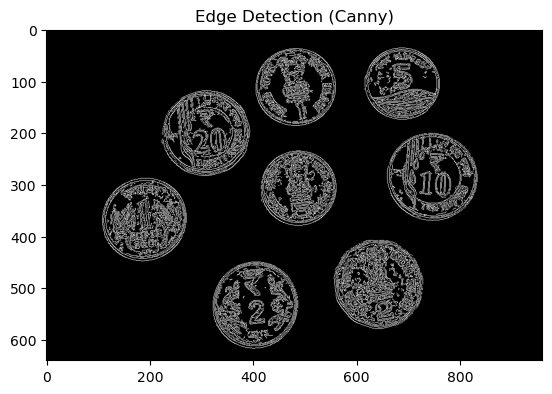

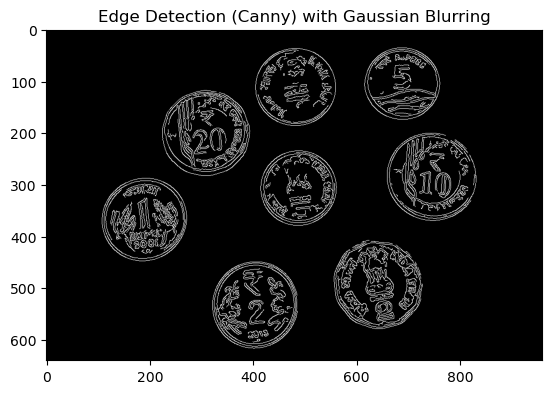

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./coin_img/coins.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Use Canny edge detection
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edges_2 = cv2.Canny(blurred, threshold1=100, threshold2=200)

# Visualize the edges with and without gaussian blurring
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Canny)")
plt.show()

plt.imshow(edges_2, cmap='gray')
plt.title("Edge Detection (Canny) with Gaussian Blurring")
plt.show()

Canny edge detecion with morphological closing

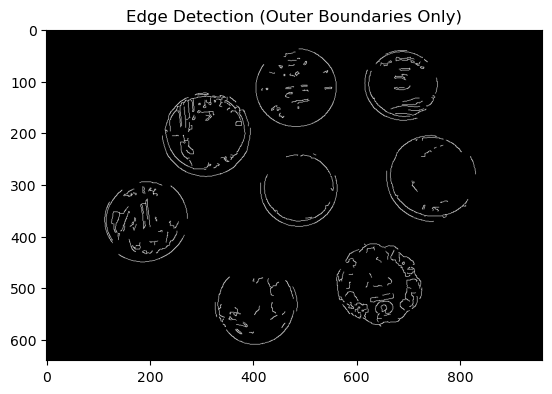

In [41]:
# Apply morphological closing to remove small holes
# kernel = np.ones((6, 6), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))  # Stronger effect

closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)

# Use Canny edge detection
edges_3 = cv2.Canny(closed, threshold1=100, threshold2=200)

# Visualize the edges
plt.imshow(edges_3  , cmap='gray')
plt.title("Edge Detection (Outer Boundaries Only)")
plt.show()


#### Part 1b. Segmentation of Each Coin
Using cv2's coutour detection function

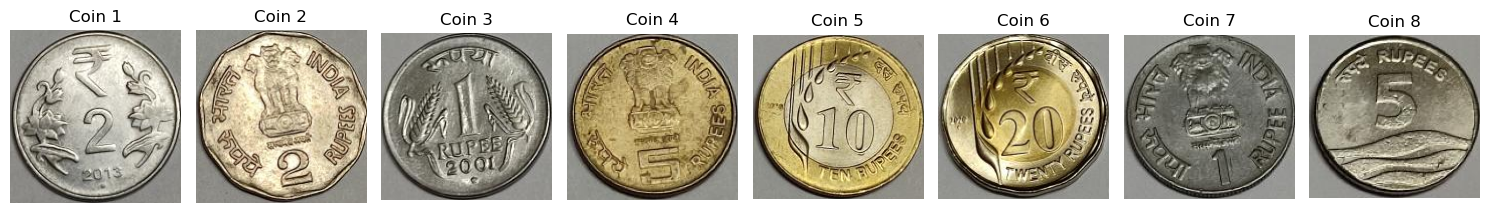

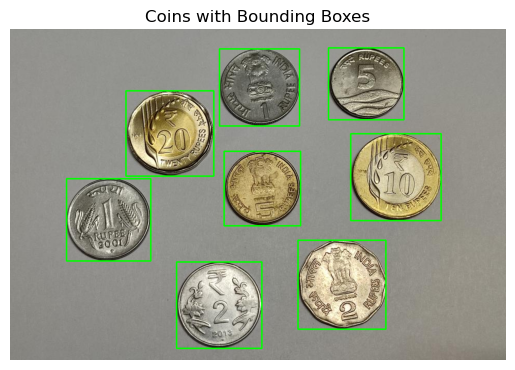

In [42]:
# Step 2: Apply adaptive thresholding or Otsu's method to binarize the image
_, binary_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Find contours of the coins in the binary image
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to visualize the segmentation
segmented_img = img.copy()

# List to hold the segmented coin regions
segmented_coins = []

# Step 4: Loop through the contours to isolate each coin
for contour in contours:
    # Ignore small contours which may be noise
    if cv2.contourArea(contour) > 1000:  # You can adjust the area threshold based on the size of coins
        # Get the bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Crop the coin region from the original image
        coin_region = img[y:y+h, x:x+w]

        # Append the segmented coin to the list
        segmented_coins.append(coin_region)

        # Draw a bounding box around each coin in the image for visualization
        cv2.rectangle(segmented_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Step 5: Visualize the segmented coins
fig, axes = plt.subplots(1, len(segmented_coins), figsize=(15, 5))
for i, coin in enumerate(segmented_coins):
    axes[i].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"Coin {i+1}")
plt.tight_layout()
plt.show()

# Optionally, visualize the image with bounding boxes around the coins
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title("Coins with Bounding Boxes")
plt.axis('off')
plt.show()


Working on overlapping coins



##### Watershed algorithm

In [43]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


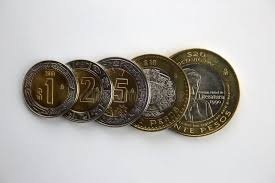

In [44]:
# Plot the image
def imshow(img, ax=None):
	if ax is None:
		ret, encoded = cv2.imencode(".jpg", img)
		display(Image(encoded))
	else:
		ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		ax.axis('off')

#Image loading
img = cv2.imread("./coin_img/overlap_coins.jpg",3)
# Show image
imshow(img)


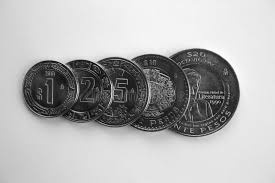

In [45]:
#image grayscale conversion
try:
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
except:
  gray = img
imshow(gray)


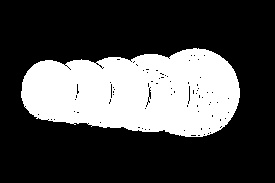

In [46]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
							160, 255,
							cv2.THRESH_BINARY_INV)

imshow(bin_img)


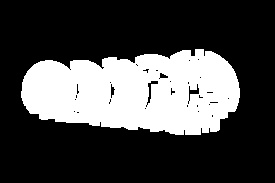

In [47]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img,
						cv2.MORPH_OPEN,
						kernel,
						iterations=3)
imshow(bin_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


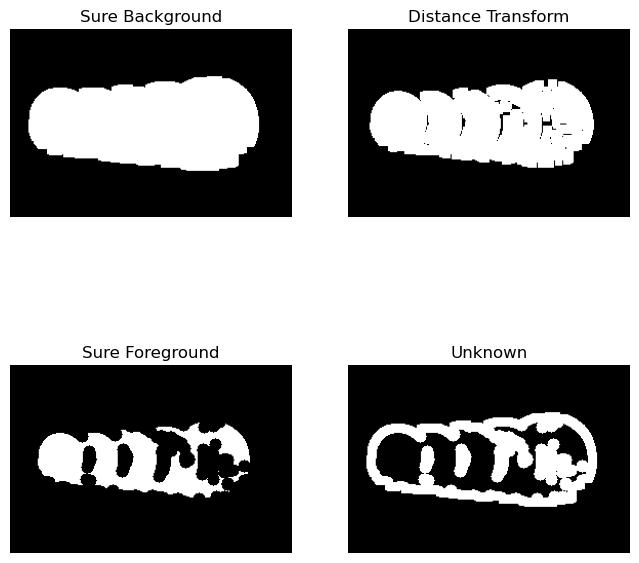

In [48]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.22 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


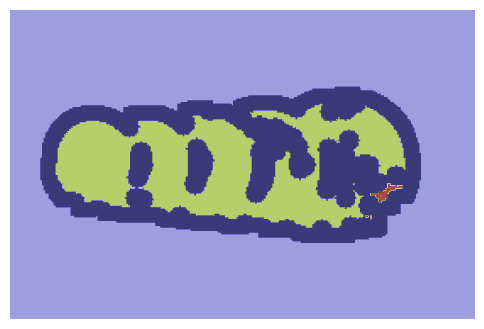

3


In [49]:
# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

print(len(img.shape))
# if len(img.shape) == 2:  # If grayscale, convert to BGR
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)



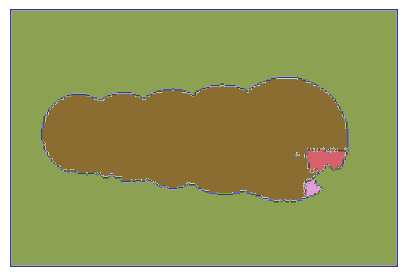

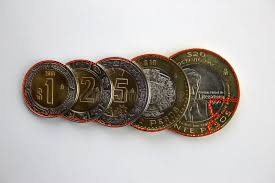

In [50]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

# Create a binary image in which only the area of the label is in the foreground
#and the rest of the image is in the background
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=1)
imshow(img)


In [51]:
# From Watershed algorithm. Total coins = num of labels - 2
print(f"Total number of coins detected: {len(labels) - 2}")


Total number of coins detected: 5




### Part 1c: Count the Total Number of Coins



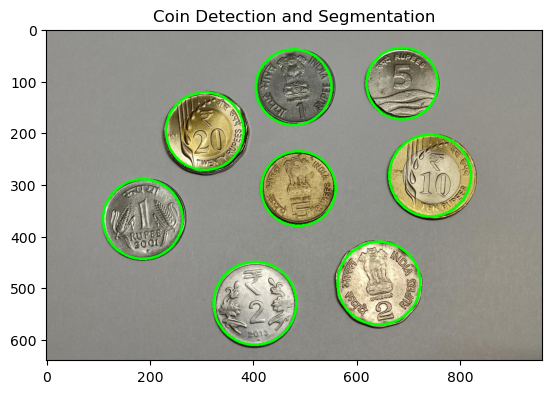

In [52]:
# Detect circles using Hough Circle Transform
# Load the image
img = cv2.imread('./coin_img/coins.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=150,
                           param1=50, param2=150, minRadius=20, maxRadius=100)
# Convert circles to integer
circles = np.round(circles[0, :]).astype("int")

# Visualize the circles on the original image
for (x, y, r) in circles:
    cv2.circle(img, (x, y), r, (0, 255, 0), 4)

# Display the image with detected coins
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Coin Detection and Segmentation")
plt.show()


In [ ]:
# Hough Transform. no. of coins = no. of circles
num_coins = len(circles)
print(f"Total number of coins detected: {num_coins}")


Total number of coins detected: 8


In [55]:
# Contour detection: No of coins = no of contours
def count_coins(segmented_coins):
    return len(segmented_coins)

# Count the total number of coins
total_coins = count_coins(segmented_coins)

# Display the final count
print(f"Total number of coins detected: {total_coins}")


Total number of coins detected: 8
